(Validation)=
# Performance evaluation of Sea ice thickness retrieval


For the performance evaluation of the sea ice thickness retrieval the Round Robin data Package (RRDP) in version 3.0 from {cite}`Pedersen2021`, is used. The part of the dataset relevant here is the thin ice reference dataset 
It contains brightness temperatures and thin ice thickness retrieved from SMOS. For this evaluation of the algorithm, it can not be used directly since the 53° degree incidence angle equivalent brightness temperatures are not part of the dataset. We extracted the corresponding locations at the given days from SMOS L1C data in version 7.24. 

In [2]:
using Revise
using Pkg
Pkg.activate("../sit_atbd_env_jl")
includet("../algorithm/CIMR_IO_tools.jl")
using PythonPlot 
using Downloads:download
using CSV
using DataFrames
using Optim
using ForwardDiff
using Dates
using YAML
using Printf
using ZipFile
using Statistics
using Markdown
using StaticArrays
using NCDatasets
using LinearAlgebra

  Activating project at `~/SeaIceThickness_ATBD_V2/sit_atbd_env_jl`


In [4]:
#python stuff
using PythonCall
mpl=pyimport("matplotlib")
mpl.use("agg")
plt=pyimport("matplotlib.pyplot")
#matplotlib_inline=pyimport("matplotlib_inline")
#@py from IPython.display import set_matplotlib_formats
#ipd=pyimport("IPython.display")
#ipd.set_matplotlib_formats("png")
ccrs=pyimport("cartopy.crs")
cfeature=pyimport("cartopy.feature")
pyproj=pyimport("pyproj")

Python: <module 'pyproj' from '/home/huntemann/SeaIceThickness_ATBD_V2/.venv/lib/python3.12/site-packages/pyproj/__init__.py'>

In [5]:
zfn="../data/RRDP_v3.zip"
if !isfile(zfn)
    download("https://figshare.com/ndownloader/files/31422043",zfn)
end

"../data/RRDP_v3.zip"

In [7]:
params=YAML.load_file("fit_params.yml")
tbh_params,tbv_params,pI,pQ=getindex.(Ref(params),["ph","pv","pI","pQ"])

ff(p)=x->p[2]-(p[2]-p[1])*exp(-x/p[3])

sit_h=ff(tbh_params)
sit_v=ff(tbv_params)

function lm_retrieval(Ta,Sₑ,Sₐ,xₐ,F)
    #lm method after Rodgers 2000
    #target: find x so that F(x)=Ta, given
    #Ta: measurement vector
    #Sₑ: error covariance of measurement
    #Sₐ: error covariance of physical state 
    #xₐ: expected physical state (also used as start, i.e. first guess)
    #F: the forward model translating measument space into state space
    if any(isnan.(Ta))
        return NaN,NaN
    end
    Sₐ⁻¹=inv(Sₐ)
    Sₑ⁻¹=inv(Sₑ)
    #function to minimize with changing input x
    J(y,x,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)=(y.-F(x))'*(Sₑ⁻¹*(y.-F(x)))+(xₐ.-x)'*(Sₐ⁻¹*(xₐ.-x)) #first two temrs of eq 5.3
    xᵢ=copy(xₐ)
    Jᵢ=J(Ta,xᵢ,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
    γ=1e-5 #set to 0 for gauss newton
    for i=1:50
        Kᵢ=ForwardDiff.jacobian(F,xᵢ)
        Ŝ⁻¹=Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ #eq 5.13
        xᵢ₊₁=xᵢ+((1+γ)*Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ)\(Kᵢ'*Sₑ⁻¹*(Ta-F(xᵢ))-Sₐ⁻¹*(xᵢ-xₐ)) #eq 5.36
        Jᵢ₊₁=J(Ta,xᵢ₊₁,Sₑ⁻¹,Sₐ⁻¹,xₐ,F)
        d²=(xᵢ-xᵢ₊₁)'*Ŝ⁻¹*(xᵢ-xᵢ₊₁) #eq 5.29
        if Jᵢ₊₁<Jᵢ #accepting & rejecting criterion from our local OEM
            γ/=2
        else
            γ*=10
            continue
        end
        xᵢ=xᵢ₊₁
        if d²<1e-10
            break
        end
        Jᵢ=Jᵢ₊₁
    end
    Kᵢ=ForwardDiff.jacobian(F,xᵢ)
    Ŝ=inv(Sₐ⁻¹+Kᵢ'*Sₑ⁻¹*Kᵢ) # eq 5.38
    
    return xᵢ,Ŝ
end


retrievallm(h,v)=first.(lm_retrieval(SA[h,v],SA[25 15;15 25.0],SMatrix{1,1,Float64,1}(20000.0),SA[100.],Fw_TB))

function retrieval(Ta,Se,Sa,xa,F)
    # easy retrieval method
    # Ta is a vector of length of input for one single retrieval length N
    # Se is the error covariance matrix of the input, i.e. length N x N
    # Sa is the error covariance matrix of the output, i.e. length M x M (the error of the background value)
    # xa is a background value where Sa is the error of, i.e. a vector of length M
    # F is a forward model receiving a input vector of length N and return an output of length M
    # ymin and ymax are the limits of the oupt regime where ot search in, both are of length M
    # returns Y, the output vector
    
    #defining error function to menimize as χ² 
    χ²(y,x,Se)=(y.-F(x))'*(Se\(y.-F(x)))
    χ²(y,x,Se,Sa,xa)=χ²(y,x,Se)+(xa.-x)'*(Sa\(xa.-x))
   if length(xa)==0
        y=[maximize(y->-χ²(Ta,y,Se,Sa,xa),0,10000).res.minimizer]
    else
        res=optimize(y->χ²(Ta,y,Se,Sa,xa),xa)
        y=res.minimizer
    end
    
    M=ForwardDiff.jacobian(F,y)
    yerr=inv(inv(Sa)+M'*inv(Se)*M)
    return y[1],yerr[1]
end
    
Fw_TB(x)=[sit_h(x[1]), sit_v(x[1])]
Fw_IQ(x)=[fI(x[1]), fQ(x[1])]

c=15
retrieval(h,v)=retrieval([h,v],[25 c;c 25.0],fill(20000.,1,1),[100.],Fw_TB)


#original parameters used in ub retrieval
qparams = [51.0, 19.4, 31.8, 1.65]  # HBparams
ff2_p= [100.2,234.1,12.7]




I(p)=f(x)=p[2]-(p[2]-p[1])*exp(-x/p[3])
Q(p)=f(x)=p[2]-(p[2]-p[1])*exp(-(x/p[3])^p[4])

fI(x)=I(ff2_p)(x)
fQ(x)=Q(qparams)(x)

#fI(pI)=I(ff2_p)(x)
#fQ(pQ)=Q(qparams)(x)

cost(II,QQ)=f(x)=(fI(x)-II)^2+(fQ(x)-QQ)^2
retrieval_hun(ii,qq)=maximize(x->-cost(ii,qq)(x),0,200).res.minimizer 

retrieval_hun (generic function with 1 method)

In [8]:
zf=ZipFile.Reader(zfn);
idxs=findall(x->(occursin("RRDP_v3/UB_THINICE/S",x)),getfield.(zf.files,:name))
D=DataFrame[]
for idx in idxs
    push!(D,CSV.read(read(zf.files[idx]),DataFrame;skipto=3,header=2))
#    fio,DataFrame;skipto=3,header=2)
end

allD=vcat(D...);
sort!(allD,["date"]);

d=allD.date[1]
datef=dateformat"yyyymmdd"
Dates.format(d,dateformat"yyyymmdd")

for r in eachrow(allD)
    cday=Dates.format(r.date,datef)
  #  println("$(r.latitude) $(r.longitude) 51/55 $cday $cday")
end
rrdp_extract=CSV.read("../data/rrdp_thinice_51-55_724.txt",DataFrame,header=["date","tbh53","tbv53","mean_inc","tbh53_std","tbv53_std"]);
fulltable=hcat(allD,rrdp_extract,makeunique=true);

In [9]:
function trf(x)
    try 
        return parse(Float64,x)
    catch 
        return NaN
    end
end

nsit=first.(retrieval.(fulltable.tbh53,fulltable.tbv53))
vidx=(.~isnan.(fulltable.tbv53)) .&& (fulltable.SIT.>0) .&& (fulltable.SIT.!=0.51);

In [10]:
d1=fulltable.SIT[vidx]*100.
d2=nsit[vidx]
M=[one.(d1) d1]
p=M\d2 #linear algebra least square fit :-D
r2 = cor(d1,d2)^2

0.6408939277925975

In [11]:
let m=(@sprintf "%.1f" p[2]), r=(@sprintf "%.1f" sqrt(r2)), b=(@sprintf "%.1f" p[1])
"""
Figure {numref}`fig:refcompare` shows the direct comparison of the reference dataset.
The algorithm shows slightly higher ice thickness. A least square fit result in a slope of $m and y-intersection of $b.
The discrepency might come from the difference in incidence angle or the difference in the data version from the SMOS satellite.
While the original dataset had a fixed upper limit at 50&nbsp;cm ice thickness, the retrieval described here does not have this limit.
The correlation coefficient between the datasets is r= $r.
""" |> x->display("text/markdown",x)
end

Figure {numref}`fig:refcompare` shows the direct comparison of the reference dataset.
The algorithm shows slightly higher ice thickness. A least square fit result in a slope of 1.5 and y-intersection of -3.0.
The discrepency might come from the difference in incidence angle or the difference in the data version from the SMOS satellite.
While the original dataset had a fixed upper limit at 50&nbsp;cm ice thickness, the retrieval described here does not have this limit.
The correlation coefficient between the datasets is r= 0.8.


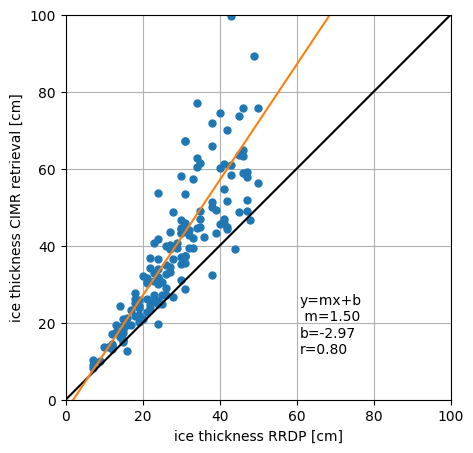

~~~markdown
```{figure} figures/figure_fig:refcompare.png
:name: fig:refcompare

Scatter plot between the RRDP reference dataset and the CIMR retrieval using SMOS data.
```

~~~

In [12]:
fig=plt.figure(figsize=[5,5])
ax=fig.add_subplot(111)
ax.plot(fulltable.SIT[vidx]*100.,nsit[vidx],marker="o",ms=5,lw=0)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.plot([0,100],[0,100],color="k")
x=0:100
ax.plot(x,p[1].+p[2].*x)
ax.annotate((@sprintf "y=mx+b\n m=%.2f\nb=%.2f\nr=%.2f" p[2] p[1] sqrt(r2) ),xy=(0.6,0.2),xycoords="figure fraction",fontsize=10)
ax.set_ylabel("ice thickness CIMR retrieval [cm]")
ax.set_xlabel("ice thickness RRDP [cm]")
ax.set_aspect("equal", adjustable="box")
ax.grid()

#plt.grid()


plot_with_caption(fig, "Scatter plot between the RRDP reference dataset and the CIMR retrieval using SMOS data.", "fig:refcompare")

In Figure {numref}`fig:rrdplocs` the locations an corresponding ice thicknesses are shown which resultet in a valid data point in the comparsion to {numref}`fig:refcompare`. Most data points are coming from the Barents and Kara Seas as well as the Chuckchi Sea, while only few data points come from the Laptev Sea and the Baffin Bay area.

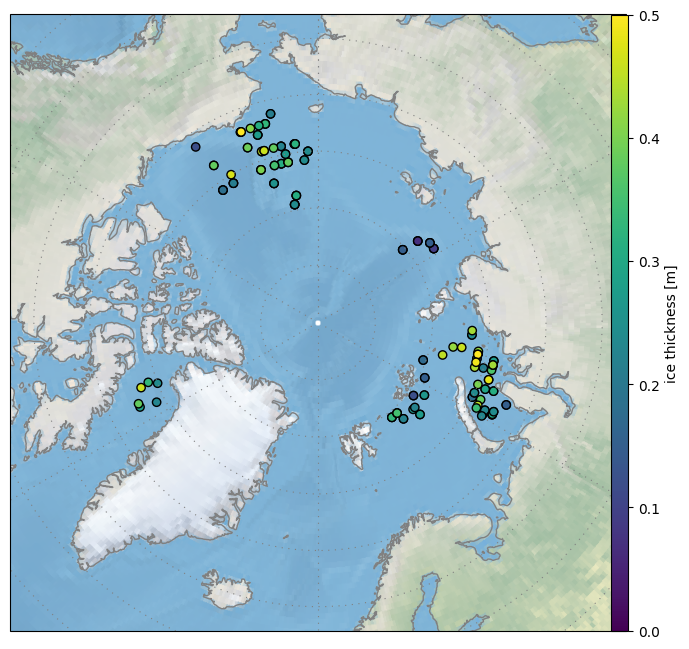

~~~markdown
```{figure} figures/figure_fig:rrdplocs.png
:name: fig:rrdplocs

Location and values of the RRDP thin ice dataset for valid comparison data.
```

~~~

In [13]:
lats=fulltable.latitude
lons=fulltable.longitude;
mapccrs=ccrs.LambertAzimuthalEqualArea(central_latitude=90);
fig=plt.figure(figsize=[8,8])
ax=fig.add_subplot(111,projection=mapccrs)
cax=fig.add_subplot(1,30,30)

ax.set_extent((-3e6,3e6,-3e6,3e6),crs=mapccrs)
ax.stock_img()
ax.coastlines("50m",color="gray")
im=ax.scatter(lons[vidx],lats[vidx],c=fulltable.SIT[vidx],transform=ccrs.PlateCarree(),edgecolor="black",vmin=0,vmax=.50)
ax.gridlines(draw_labels=false,color="gray",linestyle=(0, (1, 5,)))
fig.colorbar(im,cax=cax)
cax.set_ylabel("ice thickness [m]")

plot_with_caption(fig, "Location and values of the RRDP thin ice dataset for valid comparison data.", "fig:rrdplocs")

In [14]:
#read the smos brightness temperatures in incidence angle 50 to 56 in h and v pol and the std
#fn="../data/20221011_TBs.nc"
fn="../data/20211016_TBs.nc"
sdata=NCDataset(fn,"r") do ds
    tbv=ds["TB_val_v_inc_50_56"][:,:]
    tbh=ds["TB_val_h_inc_50_56"][:,:]
    tbvstd=ds["TB_std_v_inc_50_56"][:,:]
    tbhstd=ds["TB_std_h_inc_50_56"][:,:]
    return (;tbv,tbh,tbvstd,tbhstd)
end

sdatao=NCDataset(fn,"r") do ds
    tbv=ds["TB_val_v_inc_40_50"][:,:]
    tbh=ds["TB_val_h_inc_40_50"][:,:]
    return (;tbv,tbh)
end



(tbv = Float32[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], tbh = Float32[NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

In [15]:
function retrieve_smos_old(sdatao)
    sit=fill(NaN,size(sdata.tbv))
    for i in eachindex(sdatao.tbh)
        if isnan(sdatao.tbh[i])
            continue
        end
        sit[i]=retrieval_hun(sdatao.tbh[i]/2+sdatao.tbv[i]/2,sdatao.tbv[i]-sdatao.tbh[i])
    end
    return sit
end


   
    

retrieve_smos_old (generic function with 1 method)

In [22]:
sit_old=retrieve_smos_old(sdatao)

In [23]:
function retrieve_smos(sdata)
    sit=fill(NaN,size(sdata.tbv))
    siterr=fill(NaN,size(sdata.tbv))


    for i in eachindex(sdata.tbh)
        tbh=sdata.tbh[i] |> Float64
        tbv=sdata.tbv[i] |> Float64
        tbhstd=sdata.tbhstd[i] |> Float64
        tbvstd=sdata.tbvstd[i] |> Float64
        mstd=tbhstd^2/2+tbvstd^2/2
        mstd=clamp(mstd,9.0,100.0)
        corr=0.6*mstd#sqrt(tbhstd^2*tbvstd^2)
        #Sₑ=SA[tbhstd^2 corr;corr tbvstd^2]
        Sₑ=SA[mstd corr;corr mstd]
        if (~isposdef(Sₑ)) || isnan(tbh)
            sit[i],siterr[i]=NaN,NaN
            continue
        end
        maxerr=144
#        Sₑ=SA[25 15;15 25]
        out=first.(lm_retrieval(SA[tbh,tbv],Sₑ,SMatrix{1,1,Float64,1}(maxerr^2),SA[100.],Fw_TB))
        sit[i]=out[1]
        
        err_cfdd=cfdd_unc(sit[i])
        ntbh,ntbv=ow_mix_tb(tbh,tbv,-0.05)
        sit_min=first.(lm_retrieval(SA[ntbh,ntbv],Sₑ,SMatrix{1,1,Float64,1}(maxerr^2),SA[100.],Fw_TB))[1]
        
        ntbh,ntbv=ow_mix_tb(tbh,tbv,0.05)
        sit_max=first.(lm_retrieval(SA[ntbh,ntbv],Sₑ,SMatrix{1,1,Float64,1}(maxerr^2),SA[100.],Fw_TB))[1]
        err_ow=((sit[i]-sit_max)^2+(sit[i]-sit_min)^2)^0.5
        
        siterr[i]=out[2]+err_ow^2+err_cfdd^2
    end
    return sit,siterr
end

function ow_mix_tb(tbh,tbv,owf)
    owtbh,owtbv=Fw_TB(0)
    ntbh=(tbh*(1-owf)+(owtbh*owf))
    ntbv=(tbv*(1-owf)+(owtbv*owf))
    return ntbh,ntbv
end

cfdd(temp,duration)=1.33*(-(temp+1.8)*duration)^0.58

sittime(sit,temp)=-(max(0,sit)/1.33)^(1/0.58)/(temp+1.8)

function cfdd_unc(sit)
    t=sittime(sit,-25)
    return (cfdd(-25,t+1)-cfdd(-25,t))*0.68
end


cfdd_unc (generic function with 1 method)

In [25]:
sit,siterr=retrieve_smos(sdata)

## CIMR SIT vs SMOS SIT
The CIMR ATBD retrieval is applied to daily gridded SMOS brightness temperature data for one day in the arctic for demonstration in {numref}`fig:CIMR_SIT_example` for the 16th of October 2021. The central Arctic is not well covered as the retrieval work on an incidence angle of 53° (SMOS averaged 50°-56°).
In this incidence angle regime SMOS is nearly forward looking and thus has a very narrow swath.
Typical multi year ice regions are covered with thick ice in the retrieval and are marked with a high uncertainty. Note that beyond 80cm SIT data corresponds to the extrapolation range of the agorithm and is not trustwothy. This is indicated with the high uncertainty value of the retrieval. Thinner ice is well represented at the ice edge as the 16th of October typically corresponds to a date of early freeze-up date with considerably high new ice formation. The uncertainty over open water is associated with the fact that moderate winds may increase the brightness temperatures. Which would be detected as increased ice thickness by the retrieval.



In [16]:
#mycrs=ccrs.CRS("+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
mycrs=ccrs.NorthPolarStereo(central_longitude=-45,true_scale_latitude=70)
xll=-3850000
yll=-5350000
xd=12.5e3
yd=12.5e3

mycrs.transform_point(0,90,ccrs.PlateCarree())


Python: (0.0, 0.0)

In [17]:
function plot_maps(sit,siterr)
fig,axs=plt.subplots(figsize=[12,8],ncols=2,subplot_kw=PyDict(Dict("projection"=> mapccrs)))

#ax=fig.add_subplot(projection=mapccrs)
cmap="viridis"
ax=axs[0]
ax.set_title("SIT [cm]")
ax.set_extent((-3e6,3e6,-3e6,3e6),crs=mapccrs)
im1=ax.imshow(rotl90(sit),extent=[xll,xll+xd*size(sit,1),yll,yll+yd*size(sit,2)],transform=mycrs,cmap="viridis",vmax=200)
ax.coastlines(color="black")
cax1=ax.inset_axes((0.85,0.5,0.02,0.4))
plt.colorbar(im1,cax=cax1)
ax.add_feature(cfeature.NaturalEarthFeature("physical","land","50m"),facecolor="lightgray")

ax=axs[1]
ax.set_title("SIT error [cm]")
ax.set_extent((-3e6,3e6,-3e6,3e6),crs=mapccrs)
cax2=ax.inset_axes((0.85,0.5,0.02,0.4))

im2=ax.imshow(rotl90(siterr.^0.5),extent=[xll,xll+xd*size(sit,1),yll,yll+yd*size(sit,2)],transform=mycrs,vmin=0,vmax=200,cmap=cmap)
ax.coastlines(color="black")
plt.colorbar(im2,cax=cax2)
ax.add_feature(cfeature.NaturalEarthFeature("physical","land","50m"),facecolor="lightgray")
ax.annotate("2021-10-16",xy=(0.8,0.01),xycoords="axes fraction")

fig.subplots_adjust(wspace=0.01)
#return display(MIME("image/svg+xml"),fig)
return fig
end

plot_maps (generic function with 1 method)

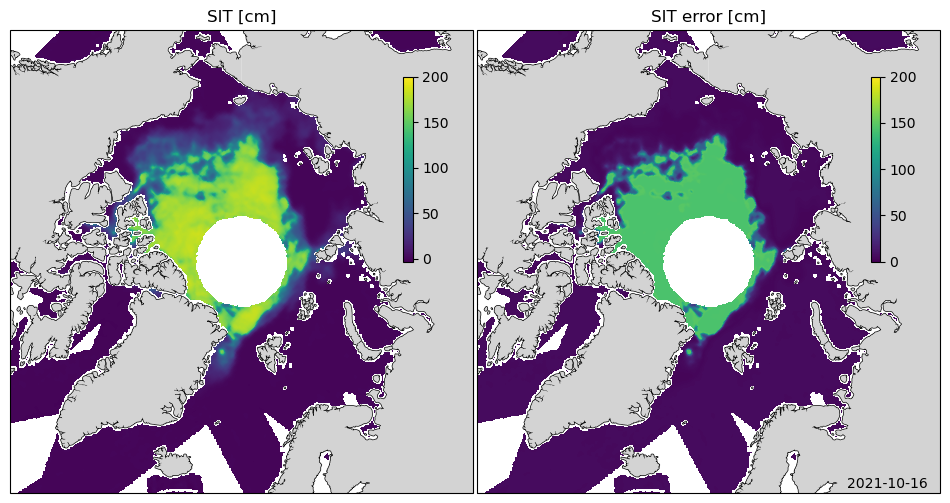

~~~markdown
```{figure} figures/figure_fig:CIMR_SIT_example.png
:name: fig:CIMR_SIT_example

CIMR SIT retrieval applied on SMOS data in the Arctic, for 16th of October 2021, left: SIT, right: SIT uncertainty
```

~~~

In [18]:
fig=plot_maps(sit,siterr)
plot_with_caption(fig,"CIMR SIT retrieval applied on SMOS data in the Arctic, for 16th of October 2021, left: SIT, right: SIT uncertainty.", "fig:CIMR_SIT_example")


In [1]:
fn="https://data.seaiceportal.de/data/smos_awi/v3.3/n/2021/SMOS_Icethickness_v3.3_north_20211016.nc"
if !isfile("../data/SMOS_Icethickness_v3.3_north_20211016.nc")
    download(fn,"../data/SMOS_Icethickness_v3.3_north_20211016.nc")
end
esasit,esasiterr=NCDataset("../data/SMOS_Icethickness_v3.3_north_20211016.nc") do ds
    esasit=ds["sea_ice_thickness"][:,:,1]
    esasiterr=ds["ice_thickness_uncertainty"][:,:,1]
    outsit=fill(NaN32,size(esasit))
    outunc=fill(NaN32,size(esasit))
    for i=eachindex(esasit)
        if ismissing(esasit[i])
            continue
        end
        outsit[i]=esasit[i]*100
        outunc[i]=(esasiterr[i]*100).^2
    end
    return outsit,outunc
    
end

UndefVarError: UndefVarError: `NCDataset` not defined

For direct comparison we show the ESA SMOS SIT product in {numref}`fig:ESA_SMOS_SIT` for the Same day using the same color scale as in {numref}`fig:CIMR_SIT_example`. The central areas look a bit smoother and an overlying pattern is visible which originates from the auxiliary data as the weight of background values overpower the weight of brightness temperatures for the outcome of the retrieval {cite}`Tiankunze2014``

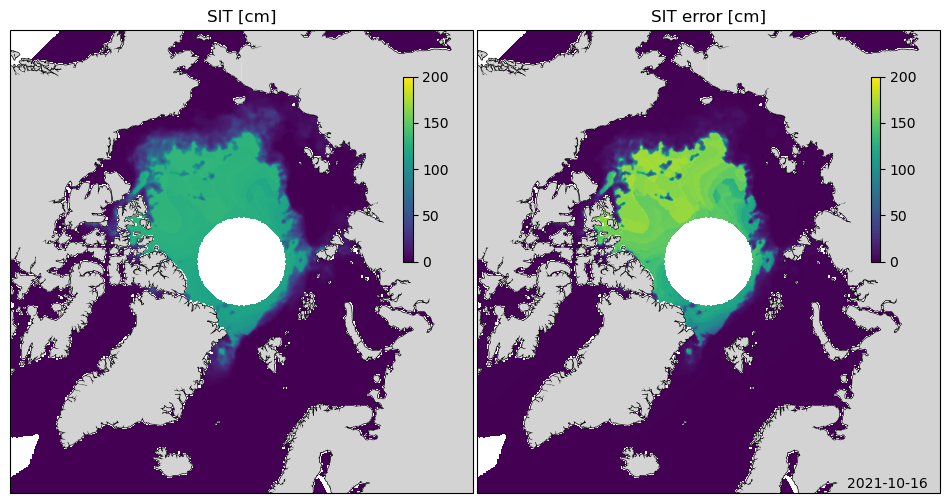

~~~markdown
```{figure} figures/figure_fig:ESA_SMOS_SIT.png
:name: fig:ESA_SMOS_SIT

ESA SMOS Sea ice thickness vs CIMR algorithm applied on SMOS data.
```

~~~

In [20]:
fig= plot_maps(esasit,esasiterr)
plot_with_caption(fig, "ESA SMOS Sea ice thickness vs CIMR algorithm applied on SMOS data.", "fig:ESA_SMOS_SIT")

A direct comparison between the ESA SIT product from SMOS and the CIMR algorithm using SMOS data is shown in {numref}`fig:SMOS_vs_CIMR`. The agreement is very high in interediate ice thickness areas, between 50 cm and 70 cm. For thin ice, the CIMR SIT gives higher values compared to the ESA SMOS SIT retrieval. This is in line with {numref}`fig:refcompare`.
The areas where the SMOS product has 0 cm ice thickness while the CIMR retrieval gives non-zero values, probably correspond to ice pixel which are land contaminated in the brightness temperatures used by the CIMR retrieval. Note that the ESA SMOS product uses data up to an incidence angle from 0°-40° which have a smaller footprint size compared to the 50°-56° used in the CIMR retrieval. More restrictive landmasking would mitigate this issue.


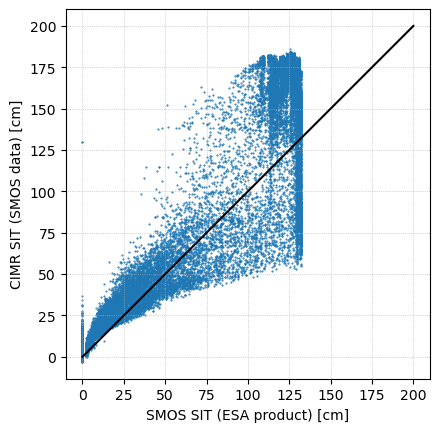

~~~markdown
```{figure} figures/figure_fig:SMOS_vs_CIMR.png
:name: fig:SMOS_vs_CIMR

ESA SMOS Sea ice thickness vs CIMR algorithm applied on SMOS data.
```

~~~

In [21]:

fig=plt.figure()
plt.scatter(esasit,sit,marker=".",s=1)
plt.ylabel("CIMR SIT (SMOS data) [cm]")
plt.xlabel("SMOS SIT (ESA product) [cm]")
plt.xticks(0:25:200)
plt.yticks(0:25:200)
plt.grid(lw=0.5,ls=":")
plt.plot([0,200],[0,200],color="k")
plt.gca().set_aspect("equal")

#plt.hexbin(sit[iceidx],esasit[iceidx])
#display(MIME("image/png"),fig)
plot_with_caption(fig, "ESA SMOS Sea ice thickness vs CIMR algorithm applied on SMOS data.", "fig:SMOS_vs_CIMR")


In {numref}`fig:UB_vs_CIMR` the CIMR algorithm is compared to algorithm used in the SMOS ice thickness roduct from the University of Bremen. Here, also the CIMR algorithm shows about 25% higher SIT values.

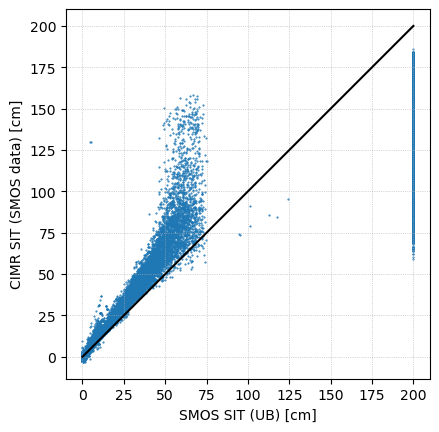

~~~markdown
```{figure} figures/figure_fig:UB_vs_CIMR.png
:name: fig:UB_vs_CIMR

Comparison of CIMR SIT retrieval (on SMOS data) with the University of Bremen SMOS SIT product.
```

~~~

In [22]:

fig=plt.figure()
plt.scatter(sit_old,sit,marker=".",s=1)
plt.ylabel("CIMR SIT (SMOS data) [cm]")
plt.xlabel("SMOS SIT (UB) [cm]")
plt.xticks(0:25:200)
plt.yticks(0:25:200)
plt.grid(lw=0.5,ls=":")
plt.plot([0,200],[0,200],color="k")

plt.gca().set_aspect("equal")

#plt.hexbin(sit[iceidx],esasit[iceidx])
#display(MIME("image/png"),fig)
plot_with_caption(fig, "Comparison of CIMR SIT retrieval (on SMOS data) with the University of Bremen SMOS SIT product.", "fig:UB_vs_CIMR")